<a href="https://colab.research.google.com/github/MUbarak123-56/qiskit-work/blob/master/quantum-protocols-algos/deutsch_jozsa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install qiskit

In [2]:
!pip install pylatexenc

In [3]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer, IBMQ, transpile
from qiskit.visualization import plot_histogram
from qiskit.providers.ibmq import least_busy
from qiskit.tools.jupyter import *

In [4]:
n = 3

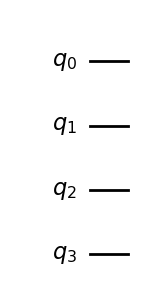

In [5]:
const_oracle = QuantumCircuit(n + 1)

output = np.random.randint(2)

if output == 1:
  const_oracle.x(n)

const_oracle.draw("mpl")


In [6]:
balanced_oracle = QuantumCircuit(n + 1)

b_str = "101"

for qubit in range(len(b_str)):
  if b_str[qubit] == "1":
    balanced_oracle.x(qubit)

balanced_oracle.barrier()

for qubit in range(n):
  balanced_oracle.cx(qubit, n)

balanced_oracle.barrier()
for qubit in range(len(b_str)):
  if b_str[qubit] == "1":
    balanced_oracle.x(qubit)



### Full Algorithm

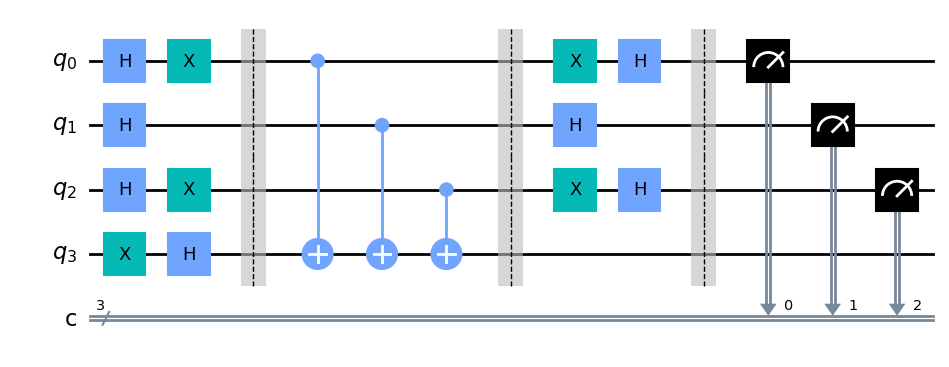

In [7]:
dj_circuit = QuantumCircuit(n + 1, n)

# Apply H-gates
for qubit in range(n):
  dj_circuit.h(qubit)

dj_circuit.x(n)
dj_circuit.h(n)

dj_circuit = dj_circuit.compose(balanced_oracle)
for qubit in range(n):
  dj_circuit.h(qubit)

dj_circuit.barrier()

for i in range(n):
  dj_circuit.measure(i, i)
dj_circuit.draw("mpl")

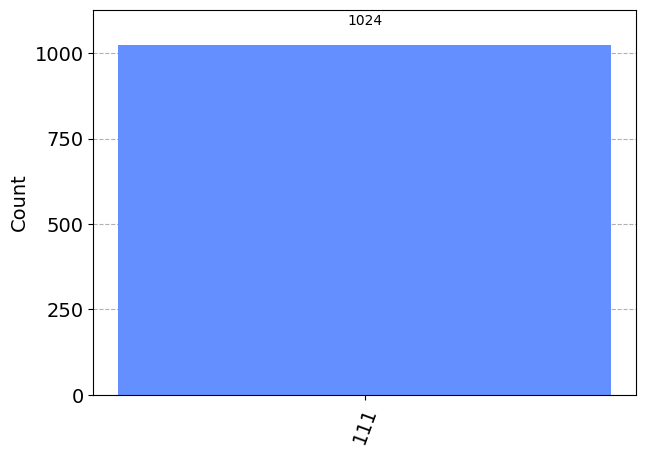

In [8]:
aer_sim = Aer.get_backend('aer_simulator')
results = aer_sim.run(dj_circuit).result()
answer = results.get_counts()

plot_histogram(answer)

In [9]:
b = np.random.randint(1,8)
b

3

In [10]:
def dj_oracle(case, n):
    # We need to make a QuantumCircuit object to return
    # This circuit has n+1 qubits: the size of the input,
    # plus one output qubit
    oracle_qc = QuantumCircuit(n+1)

    # First, let's deal with the case in which oracle is balanced
    if case == "balanced":
        # First generate a random number that tells us which CNOTs to
        # wrap in X-gates:
        b = np.random.randint(1,2**n)
        # Next, format 'b' as a binary string of length 'n', padded with zeros:
        b_str = format(b, '0'+str(n)+'b')
        # Next, we place the first X-gates. Each digit in our binary string
        # corresponds to a qubit, if the digit is 0, we do nothing, if it's 1
        # we apply an X-gate to that qubit:
        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                oracle_qc.x(qubit)
        # Do the controlled-NOT gates for each qubit, using the output qubit
        # as the target:
        for qubit in range(n):
            oracle_qc.cx(qubit, n)
        # Next, place the final X-gates
        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                oracle_qc.x(qubit)

    # Case in which oracle is constant
    if case == "constant":
        # First decide what the fixed output of the oracle will be
        # (either always 0 or always 1)
        output = np.random.randint(2)
        if output == 1:
            oracle_qc.x(n)

    oracle_gate = oracle_qc.to_gate()
    oracle_gate.name = "Oracle" # To show when we display the circuit
    return oracle_gate

In [11]:
def dj_algorithm(oracle, n):
    dj_circuit = QuantumCircuit(n+1, n)
    # Set up the output qubit:
    dj_circuit.x(n)
    dj_circuit.h(n)
    # And set up the input register:
    for qubit in range(n):
        dj_circuit.h(qubit)
    # Let's append the oracle gate to our circuit:
    dj_circuit.append(oracle, range(n+1))
    # Finally, perform the H-gates again and measure:
    for qubit in range(n):
        dj_circuit.h(qubit)

    for i in range(n):
        dj_circuit.measure(i, i)

    return dj_circuit

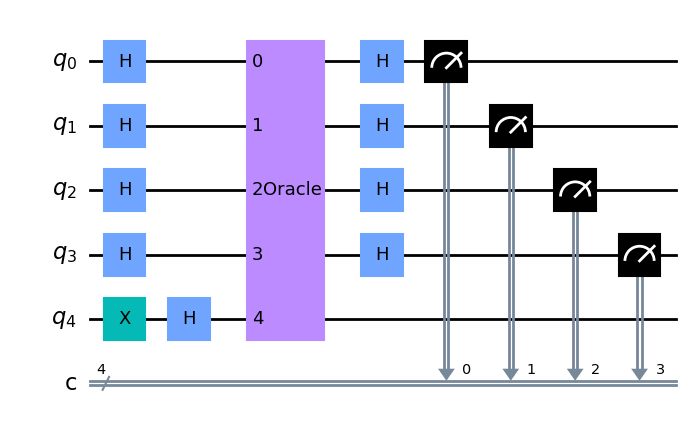

In [12]:
n = 4
oracle_gate = dj_oracle('constant', n)
dj_circuit = dj_algorithm(oracle_gate, n)
dj_circuit.draw("mpl")

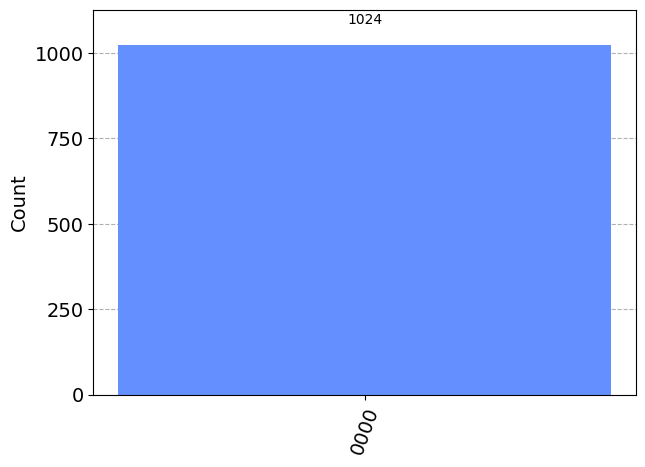

In [13]:
transpiled_dj_circuit = transpile(dj_circuit, aer_sim)
results = aer_sim.run(transpiled_dj_circuit).result()
answer = results.get_counts()
plot_histogram(answer)

In [14]:
%run cred.sh

/content/cred.sh:2: DeprecationWarning: The qiskit.IBMQ entrypoint and the qiskit-ibmq-provider package (accessible from 'qiskit.providers.ibmq`) are deprecated and will be removed in a future release. Instead you should use the qiskit-ibm-provider package which is accessible from 'qiskit_ibm_provider'. You can install it with 'pip install qiskit_ibm_provider'. Just replace 'qiskit.IBMQ' with 'qiskit_ibm_provider.IBMProvider'
  IBMQ.save_account("7ec7c3d9c61b02577a80462aeed74b169ce4defa242d2b2fc5031cabfac5f8199274a09d822b1dcd65125930a20f7c7c5f147e4785837efcc84764640599e462")
configrc.store_credentials:WARNING:2023-07-11 22:54:16,866: Credentials already present. Set overwrite=True to overwrite.


<Figure size 640x480 with 0 Axes>

In [15]:
# Load our saved IBMQ accounts and get the least busy backend device with greater than or equal to (n+1) qubits
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= (n+1) and
                                   not x.configuration().simulator and x.status().operational==True))
print("least busy backend: ", backend)

least busy backend:  ibmq_quito


In [16]:
%qiskit_job_watcher

Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

In [ ]:
from qiskit.tools.monitor import job_monitor

transpiled_dj_circuit = transpile(dj_circuit, aer_sim)
job = backend.run(transpiled_dj_circuit)
job_monitor(job, interval=2)


Job Status: job is queued (None)

In [ ]:
%qiskit_disable_job_watcher

In [ ]:
answer = job.result.get_counts()
plot_histogram(answer)